# Computer vision 992 final project
## Part one
### Calculate the homography matrix for two given images

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

First of all let's read and display both images

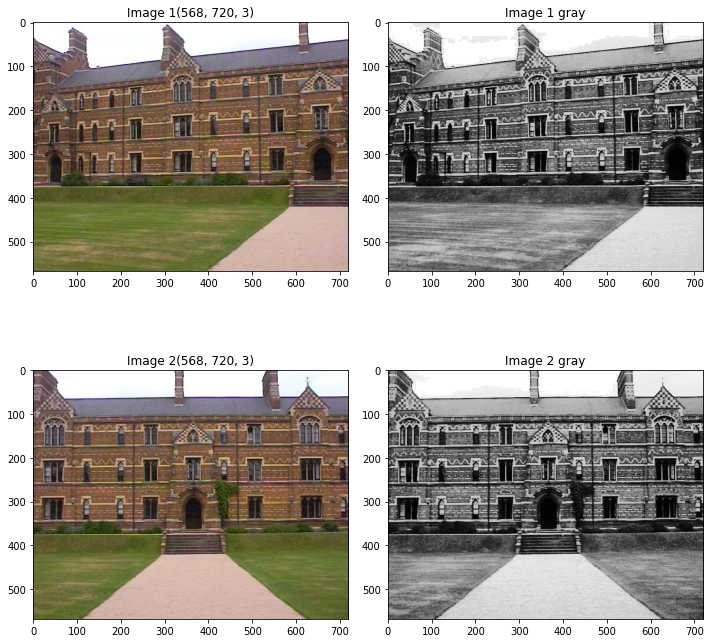

In [4]:
img1 = cv.imread("./images/building1.jpg")
img2 = cv.imread("./images/building2.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
img1_gray = cv.equalizeHist(img1_gray)
img2_gray = cv.equalizeHist(img2_gray)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.title("Image 1"+str(img1.shape))
plt.subplot(2,2,2)
plt.imshow(img1_gray, cmap="gray")
plt.title("Image 1 gray")
plt.subplot(2,2,3)
plt.imshow(img2)
plt.title("Image 2" + str(img2.shape))
plt.subplot(2,2,4)
plt.imshow(img2_gray, cmap="gray")
plt.title("Image 2 gray")
plt.tight_layout()
plt.show()

To calculate the homography matrix between two images we are in need of some **intrest points** in both images. These point could be calculated using Harris Detector method. fortunatly OpenCV has a built in function as cornerHarris that calculates these corners for us. 

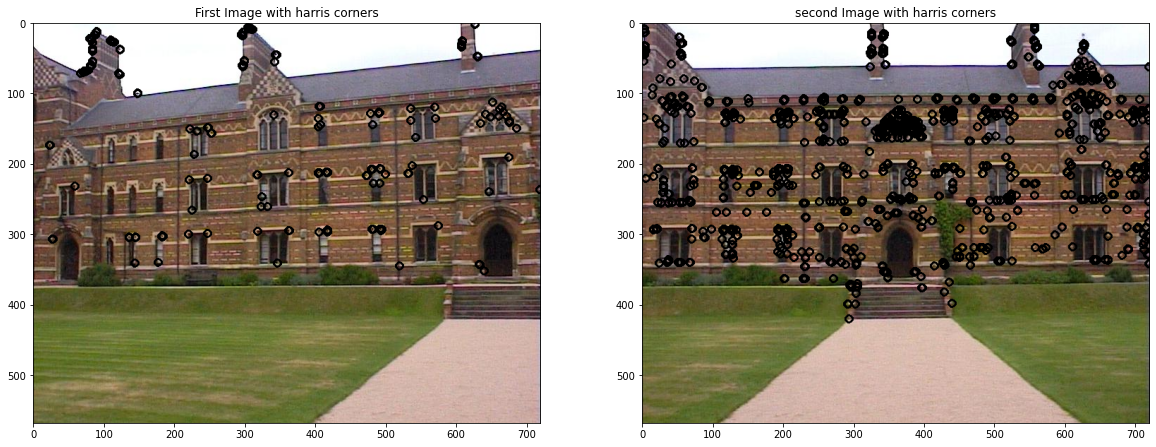

In [8]:
# Thresholds
threshold = 100
# Detector parameters
blockSize = 2
apertureSize = 3
k = 0.04
# Detecting corners
dst1 = cv.cornerHarris(img1_gray, blockSize, apertureSize, k)
dst2 = cv.cornerHarris(img2_gray, blockSize, apertureSize, k)
# Normalizing
ip1 = np.empty(dst1.shape, dtype=np.float32)
ip2 = np.empty(dst2.shape, dtype=np.float32)
# Normalization
ip1 = cv.normalize(dst1, ip1, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
ip2 = cv.normalize(dst2, ip2, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

img1_cpy = np.array(img1)
img2_cpy = np.array(img2)

kp1 = []
# Drawing a circle around corners around first image
for i in range(ip1.shape[0]):
    for j in range(ip1.shape[1]):
        if ip1[i,j] > threshold:
            kp1 += [(j,i)]
            cv.circle(img1_cpy, (j,i), 5, (0), 2)

kp2 = []
# Drawing a circle around corners in second image
for i in range(ip2.shape[0]):
    for j in range(ip2.shape[1]):
        if ip2[i,j] > threshold:
            kp2 += [(j,i)]
            cv.circle(img2_cpy, (j,i), 5, (0), 2)

# Showing the result
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img1_cpy, cmap="gray")
plt.title("First Image with harris corners")
plt.subplot(1,2,2)
plt.title("second Image with harris corners")
plt.imshow(img2_cpy, cmap="gray")
plt.show()

After detecting interspoints we need to math them to find out which points are the same in both images, to do so we use ORB and BF matcher algorithms.

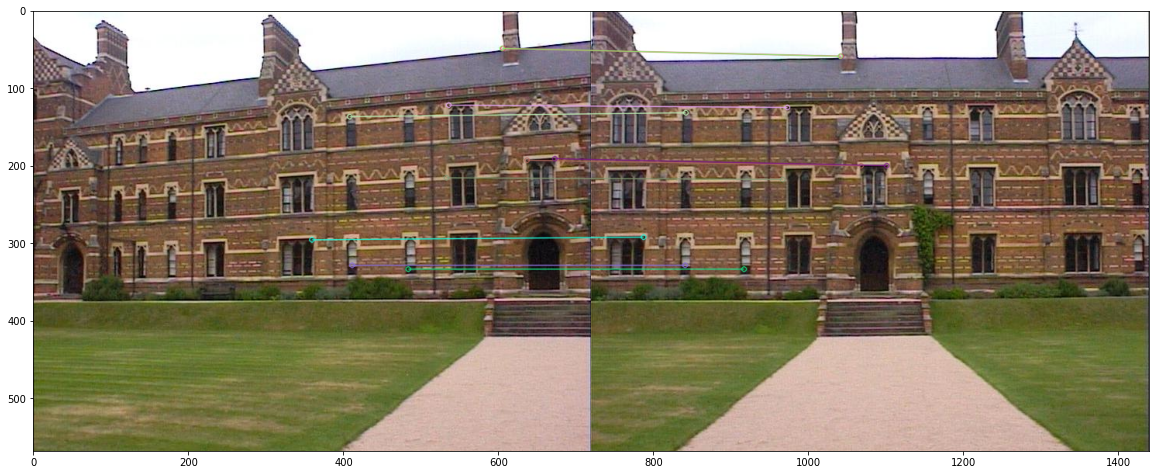

In [11]:
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,20))
plt.imshow(img3)
plt.show()

We know that the keypoints are stored in kp1 and kp2 where they are lists of feature matches for the first and second image respectively. In the cv2.ORB perspective, the feature descriptors are 2D matrices where each row is a keypoint that is detected in the first and second image.

In our case because we are using cv2.BFMatch, matches returns a list of cv2.DMatch objects where each object contains several members and among them are two important members:

- `queryIdx` - The index or row of the kp1 interest point matrix that matches
- `trainIdx` - The index or row of the kp2 interest point matrix that matches

Therefore, queryIdx and trainIdx tell us which ORB features match between the first and second image. we'd use these to index into kp1 and kp2 and obtain the pt member, which is a tuple of (x,y) coordinates that determine the actual spatial coordinates of the matches.

All we have to do is iterate through each cv2.DMatch object in matches, append to a list of coordinates for both kp1 and kp2 and we're done.

In [19]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
for mat in matches[:20]:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append([int(x1), int(y1)])
    list_kp2.append([int(x2), int(y2)])

list_kp1 = np.array(list_kp1)
list_kp2 = np.array(list_kp2)

Having these match points we can calculate the homography matrix for these two images.

In [20]:
H, ret = cv.findHomography(list_kp1, list_kp2, cv.RANSAC) # For outlyers use RANSAC
print(H)

[[ 1.17679218e+00 -4.48109529e-02 -3.37439845e+02]
 [ 1.06918077e-01  1.11989508e+00 -5.17344170e+01]
 [ 2.63802128e-04 -3.65495444e-05  1.00000000e+00]]


## Part two
### Placing a picture in a frame
At this part we will take four point in the base image and and calculate the homography matrix btween the banners corners and these four points(frame points). Then by multiplying the bannet to homography matrix we place this image insde the defined frame.

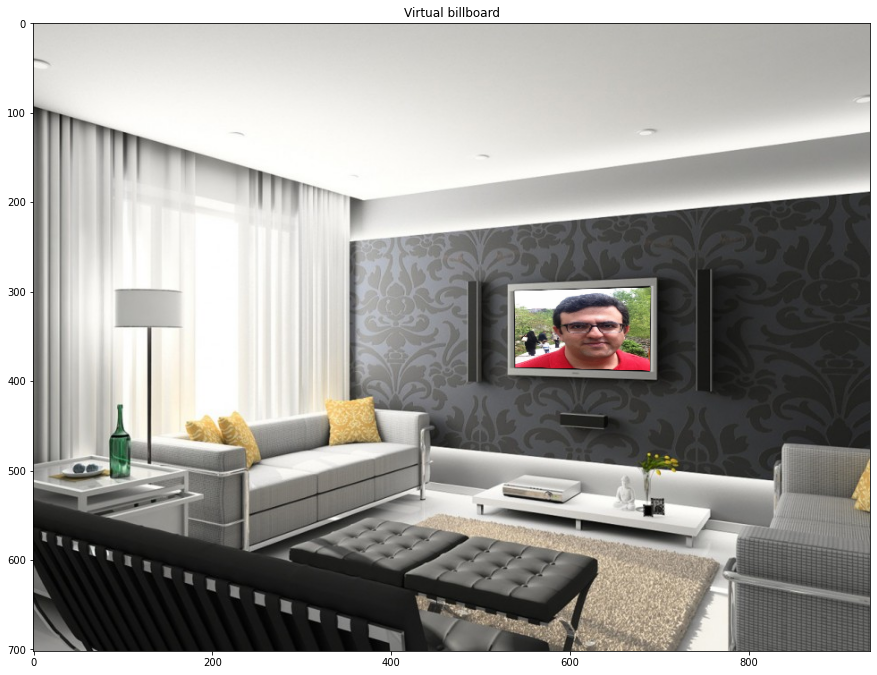

In [3]:

base_image = cv.imread('./images/room.jpg')
banner = cv.imread("./images/gholami.jpeg")

# Height and width of the banner
height, width = banner.shape[:-1]

# Frame points
frame_pts = np.array([[538,299], [690,295], [689,388], [539,384]])
base_pts = np.array([[0,0], [width-1,0],[width-1, height-1], [0,height-1]])

# Calculating homography matrix
H, status = cv.findHomography(base_pts, frame_pts)
im_out = cv.warpPerspective(banner, H, (base_image.shape[1],base_image.shape[0]))
base_image = cv.fillConvexPoly(base_image, frame_pts, 0, 16)
results = base_image + im_out
results = cv.cvtColor(results, cv.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.imshow(results)
plt.title("Virtual billboard")
plt.show()